Symbols aus Watchlist aus Tradingview
Historische Preise zu den Symbols von yh yahoo, sofern nötig, mit Zwischenspeicher, da begrenzte Umsonstabfragen
Vernüftiges Lambda pro Symbol bestimmen, z.B. <12 Trendwechsel im Jahr?, Lambda pro Symbol abspeichern
Trendwechsel abspeichern (Feststellen ob die Trendwechsel mit neuen Daten auch in der Vergangenheit entstehen können? Ob sich das ganze mit neuen Daten verschiebt)
Darstellung, plots pro symbol eine column

In [3]:
import pandas as pd
import numpy as np
import cvxpy 
import scipy
import cvxopt 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib
import matplotlib.cm as cm
from matplotlib import patheffects
import requests
import glob
import os
import datetime
import sqlite3
import pricesdb
import json
import importlib

(CVXPY) Feb 17 01:27:40 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: Das angegebene Modul wurde nicht gefunden.')


importlib.reload(pricesdb)

functions für den DB Teil

symbols in controllist laden und die dazugehörigen prices und events aus API holen und in DBs speichern

In [3]:
# Symbols aus Watchlist
watchlist = pd.read_csv('watchlist.csv', sep=';')
groupl = [10,20,30,40] #[21] 

controllist = watchlist[watchlist['group'].isin(groupl)].reset_index()
print(controllist)
for i in range(len(controllist)):
    print(controllist['tradv_ticker'][i])
    symbol = controllist['yahoo_symbol'][i]
    region = controllist['region'][i]
    
    conn = pricesdb.get_prices_update_dbs(symbol, region)
    conn = pricesdb.get_topholdings_update_dbs(symbol,region)

    

    index tradv_ticker region  rapi_response_code yahoo_symbol  group  \
0       0         ACWI     US               200.0         ACWI   10.0   
1       1         URTH     US               200.0         URTH   10.0   
2       2          NDX     US               200.0         ^NDX   10.0   
3       4          SPX     US               200.0        ^GSPC   10.0   
4       6          RUT     US               200.0         ^RUT   10.0   
5       7          DJR     US               302.0         ^DJR   10.0   
6       8        NI225     JP               302.0        ^N225   10.0   
7      10          HSI     HK               302.0         ^HSI   10.0   
8      12       SENSEX     US                 NaN       ^BSESN   10.0   
9      13          SMI     US                 NaN        ^SSMI   10.0   
10     17        DEU40     US                 NaN       ^GDAXI   10.0   
11     24       XAUUSD     US                 NaN         GC=F   10.0   
12     31        US30Y     US               302.0  

symbols in controllist aus watchlist neu laden

# nur zum Nachladen
watchlist = pd.read_csv('watchlist.csv', sep=';')
#controllist = watchlist[watchlist['group'] == 21].reset_index()
controllist = watchlist[watchlist.group.isin([10,20,30,40])].reset_index()
#controllist = watchlist[watchlist.group.isin([10,30,40])].reset_index()
controllist,range(len(controllist))

In [4]:
#import wrappers

functions für den calculations Teil

In [5]:
#@wrappers.timer
def calc_trendlines(y, lambda_list, solver, reg_norm):
    """die trendlines für die lambdas berechnen"""
    n = y.size
    ones_row = np.ones((1, n))
    D = scipy.sparse.spdiags(np.vstack((ones_row, -2*ones_row, ones_row)), range(3), n-2, n)

    trendlinesl = []
    #trendlinesd = pd.DataFrame()
    trendchangesl = []
    #trendchangesd = pd.DataFrame()
    aggtchanges1 = []
    for i, lambda_value in enumerate(lambda_list):
        x = cvxpy.Variable(shape=n)     # x is the filtered trend that we initialize    
        objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(y-x) 
                    + lambda_value * cvxpy.norm(D@x, reg_norm))    # Note: D@x is syntax for matrix multiplication    
        problem = cvxpy.Problem(objective)
        problem.solve(solver=solver, verbose=False)

        trendlinesl.append(np.array(x.value))
        
        # trendchanges index
        r = np.abs(np.diff(np.diff(np.array(x.value))))
        r75, r25 = np.percentile(r,[75,25])
        iqr = r75 - r25
        trendchanges = np.where(r > r75 + 100*iqr)[0]
        #trendchanges = dates[np.where(r > r75 + 1000*iqr)[0]].to_list()
        trendchangesl.append(trendchanges)

    return trendlinesl, trendchangesl

In [6]:
def calc_bs_signals(trendchangesd, trendlined):
    aggtchanges = trendchangesd.to_frame()
    aggtchanges['orig_index'] = aggtchanges.index
    aggtchanges = pd.merge(aggtchanges, trendlined[trendlined.index.isin(aggtchanges['date'])], on='date', how='left')
    aggtchanges['datediff'] = aggtchanges['date'].diff(periods=-1)
    aggtchanges = aggtchanges[(aggtchanges['datediff'] < datetime.timedelta(-2.0)) | aggtchanges['datediff'].isnull()]
    aggtchanges.index = aggtchanges['date']
    aggtchanges.columns = ['date','orig_index','trendlinevalue', 'diffdate']
    #trendlined.columns = ['trendlinevalue']
    #aggtchanges = pd.merge(aggtchanges, trendlined[trendlined.index == trendlined.index.max()], on='date', how='outer')
    trd = trendlined[trendlined.index == trendlined.index.max()]
    trd.columns = ['trendlinevalue']
    aggtchanges = pd.concat([aggtchanges,trd])
    trd = trendlined[trendlined.index == trendlined.index.min()]
    trd.columns = ['trendlinevalue']
    aggtchanges = pd.concat([aggtchanges,trd])    
    aggtchanges['date'] = aggtchanges.index # damit auch der erste und der letzte ein Wert in ['date'] hat
    aggtchanges = aggtchanges.sort_index()
    aggtchanges['slope_until'] = aggtchanges['trendlinevalue'].diff()#/aggtchanges['date'].diff(periods=1).dt.days
    aggtchanges['slopechange'] = aggtchanges['slope_until'].shift(-1) - aggtchanges['slope_until'] 
    #aggtchanges['slopechange1'] = aggtchanges['slope_until'].diff()
    aggtchanges['buy']  = (aggtchanges['slope_until']<0) & (aggtchanges['slope_until'].shift(-1)>0) #'kaufen'
    aggtchanges['sell'] = (aggtchanges['slope_until']>0) & (aggtchanges['slope_until'].shift(-1)<0) #'verkaufen'

    return aggtchanges

In [7]:
def transform_calc_trendlines(prices, lambda_list, solver, reg_norm):
    """
    transforms und executes calculation, from one df of prices with lists of lambdas and 
    returns a list x values dfs and trendchanges df, where x changes Steigung (Trend) 
    prices: df with columns date und close
    lambda_list:
    """
    # prices umdrehen links frühes Datum rechts späteres
    prices = prices.sort_values(by='date',ascending=True)
    # drop 
    prices = prices.dropna(subset=['close'])
    close_prices = prices['close'].copy().to_numpy()
    # log warum eigentlich? Ohne log scheint der Algorithmus instabil zu sein? 
    #close_prices = np.log(close_prices)
    # Versuch mit Skalierung auf 1
    factor = close_prices[0] # bei 1 geht es los
    close_prices *=(1.0/factor)
    prices['close_start_1'] = close_prices

    trendlinesl, trendchangesl = calc_trendlines(close_prices, lambda_list, solver, reg_norm)
    # Datümer wieder ergänzen
    trendlinedl = []
    trendchangesdl = []
    aggtchangesl = []

    resultdf = prices
    resultdf['date'] = pd.to_datetime(resultdf['date'])
    for i, (trendline, trendchanges, lambdaf) in enumerate(zip(trendlinesl, trendchangesl, lambda_list)):
        trendlined = pd.DataFrame(trendline,pd.to_datetime(prices['date']))
        trendlinedl.append(trendlined)
        trendchangesd = pd.to_datetime(prices.iloc[trendchanges]['date'])
        trendchangesdl.append(trendchangesd)

        resultdf[f'trendline_lambda_{lambdaf}'] = trendline
        resultdf[f'trendchanges_lambda_{lambdaf}'] = resultdf.index.isin(trendchanges)

        #calc b/s signals
        aggtchanges = calc_bs_signals(trendchangesd, trendlined)
        aggtchangesl.append(aggtchanges)
        aggtchanges.index = aggtchanges['orig_index']
        aggtchanges.columns = [f'agg_{colname}_lambda_{lambdaf}' if colname!= 'date' else colname for colname in aggtchanges.columns]
        resultdf = pd.merge(resultdf,aggtchanges,on='date',how='left')

    return prices, trendlinedl, trendchangesdl, aggtchangesl, resultdf


für alle symbols in der controllist, prices aus DB holen und alle calculations produzieren

In [8]:
# Hauptroutine
# all together now
# alle vorhandenen DBs lesen und die Trends rechnen und darstellen 
lambda_list = [1]#[0.5, 1]
#lambda_list = [0, 0.1, 0.5, 1, 2, 5, 10, 50, 200, 500, 1000, 2000, 5000, 10000, 100000]
#lambda_list = [0.1, 0.5, 1, 2, 5, 10]
solver = cvxpy.CVXOPT
reg_norm = 1

num_runs = 0
prev_dist=5 # week
gresultdf = pd.DataFrame()
prev_gresultdf = pd.DataFrame()
gtophdf = pd.DataFrame()

#for f in glob.glob(r"data/*.db"): #keine gute Idee, dann kann man nicht mehr steuern
for i, yahoo_symbol in enumerate(controllist['yahoo_symbol']):
    #f = glob.glob(r"data/"+controllist['yahoo_symbol'][i] + "_*.db")[0]
    f = glob.glob(r"data/"+ yahoo_symbol + "_*.db")[0]
    prices_sorted = pricesdb.get_prices_from_db(f)
    topholdingsdf, _, _ = pricesdb.get_topholdings_from_db(f)
    gtophdf = pd.concat([gtophdf,topholdingsdf])
    
    #pricesd, trendlinedl, trendchangesdl, aggtchangesl, resultdf = transform_calc_trendlines(prices_sorted, lambda_list, solver, reg_norm)
    _, _, _, _, resultdf = transform_calc_trendlines(prices_sorted, lambda_list, solver, reg_norm)
    gresultdf = pd.concat([gresultdf,resultdf])

    prev_prices_sorted = prices_sorted[:-prev_dist]
    # prev_pricesd, prev_trendlinedl, prev_trendchangesdl, prev_aggtchangesl, prev_resultdf = transform_calc_trendlines(prev_prices_sorted, lambda_list, solver, reg_norm)
    _, _, _, _, prev_resultdf = transform_calc_trendlines(prev_prices_sorted, lambda_list, solver, reg_norm)
    prev_gresultdf = pd.concat([prev_gresultdf,prev_resultdf])

    num_runs = num_runs + 1


gresultdf.to_csv(f"data\\gresult {datetime.datetime.now().strftime('%Y-%m-%d')}.csv")
prev_gresultdf.to_csv(f"data\\prev_gresult {datetime.datetime.now().strftime('%Y-%m-%d')}.csv")

db_file:data\ACWI_US.db
db_file:data\ACWI_US.db


db_file:data\URTH_US.db
db_file:data\URTH_US.db
db_file:data\^NDX_US.db
db_file:data\^NDX_US.db
data\^NDX_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^GSPC_US.db
db_file:data\^GSPC_US.db
data\^GSPC_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^RUT_US.db
db_file:data\^RUT_US.db
data\^RUT_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^DJR_US.db
db_file:data\^DJR_US.db
data\^DJR_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^N225_JP.db
db_file:data\^N225_JP.db
data\^N225_JP.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^HSI_HK.db
db_file:data\^HSI_HK.db
data\^HSI_HK.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^BSESN_US.db
db_file:data\^BSESN_US.db
data\^BSESN_US.db 

In [9]:
#controllist = controllist[controllist['tradv_ticker']!='STZX.SW']

Erweiterung:
<ul>
<li><del>trend slope change zur vorherigen trendline ausrechnen und als diff darstellen 
<li>wenn der trend slope change gross und positiv ist dann ist das ist das der erste Teil eines Kaufsignals
<li><del>vorher eng aneinanderliegende trendchanges (+-2) als einer zusammenführen
<li><del>diff aktKurs zu trendline ausrechnen und darstellen
<li>wenn der aktuelle price unter der trendline liegt ist das der zweite Teil des Kaufsignals
<li>eventuell stddev von trendline-close_price ausrechnen um zu bestimmen ob man warten soll bis der aktuelle price unter die trendline fällt
</ul>  


function für die Darstellung

In [17]:
def calc_slope_diff(trendchangesd, prev_trendchangesd, trendlined, prev_trendlined):
    # neue Events
    # 
    #new_trendchng = trendchangesd[trendchangesd > prev_trendchangesd.max()].values
    new_trendchng = trendchangesd[trendchangesd.index > prev_trendchangesd.index.max()].index
    #new_trendchngs = new_trendchng.dt.strftime('%Y-%m-%d').item().to_list()
    # Steigung
    # jeweils vom letzten - nicht vom letzten gemeinsamen 
    #timedelta = trendlined.index.max() - trendchangesd.max()
    timedelta = trendlined.index.max() - trendchangesd.index.max()
    #st_trend = (trendlined[trendlined.index==trendlined.index.max()][0].item() - trendlined[trendlined.index==trendchangesd.max()][0].item())/timedelta.days
    st_trend = (trendlined[trendlined.index==trendlined.index.max()][0].item() - trendlined[trendlined.index==trendchangesd.index.max()][0].item())/timedelta.days
    #prev_timedelta = prev_trendlined.index.max() - prev_trendchangesd.max()
    prev_timedelta = prev_trendlined.index.max() - prev_trendchangesd.index.max()
    #st_prev_trend = (prev_trendlined[prev_trendlined.index==prev_trendlined.index.max()][0].item() - prev_trendlined[prev_trendlined.index==prev_trendchangesd.max()][0].item())/prev_timedelta.days
    st_prev_trend = (prev_trendlined[prev_trendlined.index==prev_trendlined.index.max()][0].item() - prev_trendlined[prev_trendlined.index==prev_trendchangesd.index.max()][0].item())/prev_timedelta.days
    diff_st_trend = st_trend - st_prev_trend 
    
    #print(new_trendchng, diff_st_trend, prev_trendchangesd.shape, trendchangesd.shape)
    
    return new_trendchng, diff_st_trend, st_trend, st_prev_trend


Ab hier Darstellung<br>
vorher die newslist_topholdings ziehen

In [11]:
import glob

# Daten sammeln
#neueste gresult Daten lesen
f = glob.glob('data//gresult*.csv')
f.sort(reverse=True)
print(f[0])
gresultdf = pd.read_csv(f[0])

# das könnte man ersetzen durch das gresult vom letzten mal
# prev_gresultdf = pd.read_csv(f[1])
# oder
f = glob.glob('data//prev_gresult*.csv')
f.sort(reverse=True)
print(f[0])
prev_gresultdf = pd.read_csv(f[0])

#neueste sentimentDaten lesen
f = glob.glob('data//sentiment_plotdf_*.csv')
f.sort(reverse=True)
print(f[0])
sentiment_plotdf = pd.read_csv(f[0])


data\gresult 2024-02-16.csv
data\prev_gresult 2024-02-16.csv
data\sentiment_plotdf_2024-02-16.csv


In [11]:
lambda_list = [1]

In [13]:
# Ein ggresult für alles
#gresultdf, prev_gresultdf, sentiment_plotdf in ein df
# Index erstellen
gresultdf = gresultdf.set_index(['symbol',pd.to_datetime(gresultdf['date']).apply(lambda r:r.date())], drop=False)
prev_gresultdf = prev_gresultdf.set_index(['symbol',pd.to_datetime(prev_gresultdf['date']).apply(lambda r:r.date())], drop=False)
# doppelte Spalten wegnehmen
prev_gresultdf = prev_gresultdf.drop([colname for colname in prev_gresultdf.columns if not (('trend' in colname[0:5])  or ('agg_' in colname[0:5]) or ('updatedt' in colname))], axis=1)
# rename columns
prev_gresultdf.columns = ['prev_'+colname for colname in prev_gresultdf.columns if ('trend' in colname[0:5])  or ('agg_' in colname[0:5]) or ('updatedt' in colname)]

#neues gresult zusammenstellen, Basis zum 
gresultdf = pd.merge(gresultdf,prev_gresultdf, how='left', left_index=True, right_index=True) #, left_on=gresultdf.index, right_on=prev_gresultdf.index
sentiment_plotdf = sentiment_plotdf.set_index(['yahoo_symbol',pd.to_datetime(sentiment_plotdf['publishDate']).apply(lambda r:r.date())], drop=False)
sentiment_plotdf = sentiment_plotdf.rename_axis(['symbol','date'])
gresultdf = pd.merge(gresultdf,sentiment_plotdf, how='left', left_index=True, right_index=True) # left_on=gresultdf.index, right_on=sentiment_plotdf.index

gresultdf.to_csv(f"data\\ggresult {datetime.datetime.now().strftime('%Y-%m-%d')}.csv")

In [7]:
#neueste gresult Daten lesen
f = glob.glob('data//ggresult*.csv')
f.sort(reverse=True)
print(f[0])
gresultdf = pd.read_csv(f[1])

data\ggresult 2024-02-16.csv


In [13]:
# prev_gresultdf aus den zusammengefassten Spalten in gresult extrahieren
def extract_prev_gresultdf_from_gresultdf(gresultdf):
       prev_gresultdf = gresultdf[['date', 'symbol', 'region', 'open', 'high', 'low',
              'close', 'volume', 'updatedt', 'close_start_1',
              'prev_trendline_lambda_1', 'prev_trendchanges_lambda_1',
              'prev_agg_orig_index_lambda_1', 'prev_agg_trendlinevalue_lambda_1',
              'prev_agg_diffdate_lambda_1', 'prev_agg_slope_until_lambda_1',
              'prev_agg_slopechange_lambda_1', 'prev_agg_buy_lambda_1',
              'prev_agg_sell_lambda_1']]
       prev_gresultdf.columns = [colname[5:] if ('prev_' in colname[0:5]) else colname for colname in prev_gresultdf.columns ]
       prev_gresultdf = prev_gresultdf.reset_index(drop=True)
       #prev_gresultdf = prev_gresultdf[:-5] # -5 ist eine Woche vorher, geht nicht
       prev_gresultdf = prev_gresultdf.dropna(subset=['trendline_lambda_1']) # die trendline geht nur bis eine Woche vorher
       return prev_gresultdf


In [15]:
prev_gresultdf = extract_prev_gresultdf_from_gresultdf(gresultdf)

die calculation Ergebnisse darstellen

In [24]:
symbolgresult[['Negative','Neutral','Positive']].isna().all().all() == True

True

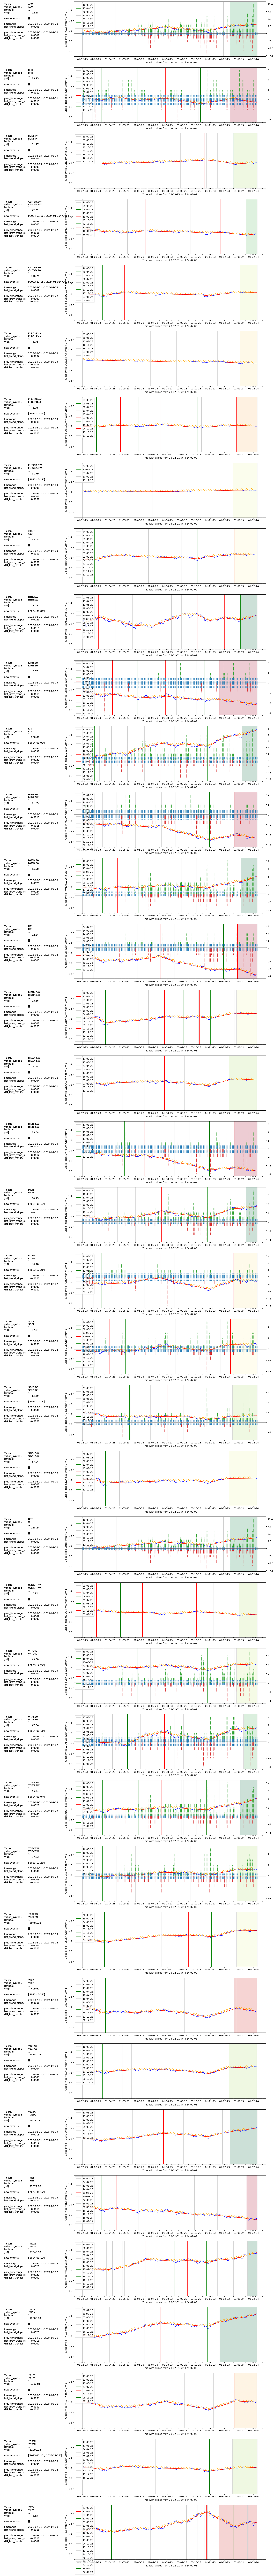

In [25]:
# Darstellung neu mit gresult
# creates a figure with multiple subplots in the form of a grid, where the number of rows is determined by the length of two lists: trendlinedl and trendlinedll. The grid's width ratio is set to 1:4
numsymbols = len(list(gresultdf['symbol'].drop_duplicates()))
numlambdas = len(lambda_list)
#fig, ax = plt.subplots(len(trendlinedl)*len(trendlinedll),2,squeeze=False, figsize=(20,num_runs*5), gridspec_kw={'width_ratios': [1, 4]})
fig, ax = plt.subplots(numlambdas*numsymbols,2,squeeze=False, figsize=(20,numsymbols*5), gridspec_kw={'width_ratios': [1, 4]})
#fig.subplots_adjust(top=0.96)
#fig.suptitle('Trendfilter L1 with lines(red=actual/orange=previous) and events')
#fig.tight_layout()
#ax = ax.ravel()
#fig.autofmt_xdate()
# A normalize function is created using matplotlib.colors.Normalize to set the minimum and maximum values for the color map. A color map cm.RdYlGn is created using the cm.ScalarMappable class.
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
#norm = matplotlib.colors.LogNorm(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn )

ax_sentimentl = []

# A nested loop is then used to plot the close prices, trend lines and trend changes on each subplot. The outer loop iterates through trendlinedl and trendlinedll, and the inner loop iterates through each element in the lists. For each iteration, the close prices and trend lines are plotted on the subplot. The x-axis is labeled with the minimum and maximum dates of the trend lines. The y-axis is labeled with the close price of the symbol.
for j, symbol in enumerate(list(gresultdf['symbol'].drop_duplicates())):
    # j symbol iterator 
    symbolgresult = gresultdf[gresultdf['symbol']== symbol]
    prev_symbolgresult = prev_gresultdf[prev_gresultdf['symbol']== symbol]
    #prev_symbolgresult = prev_symbolgresult[:-5] # -5 ist eine Woche vorher, 

    symbolgresult.index = pd.to_datetime(symbolgresult['date']).apply(lambda r:r.date())
    prev_symbolgresult.index = pd.to_datetime(prev_symbolgresult['date']).apply(lambda r:r.date())

    # wegen Warnungen bei der folgenden Op 
    pd.options.mode.chained_assignment = None
    symbolgresult['date'] = pd.to_datetime(symbolgresult['date'])
    prev_symbolgresult['date'] = pd.to_datetime(prev_symbolgresult['date'])
    
    for i, lmbda in enumerate(lambda_list):
        trendlined = symbolgresult['trendline_lambda_1']
        prev_trendlined = prev_symbolgresult['trendline_lambda_1']
        #1208 prev_trendlined = symbolgresult['prev_trendline_lambda_1']


        trendchangesd = symbolgresult[symbolgresult['trendchanges_lambda_1'] == True]['trendchanges_lambda_1']
        prev_trendchangesd = prev_symbolgresult[prev_symbolgresult['trendchanges_lambda_1'] == True]['trendchanges_lambda_1']
        #1208 prev_trendchangesd = symbolgresult[symbolgresult['prev_trendline_lambda_1'] == True]['prev_trendchanges_lambda_1']
        #aggtchanges ersetzen mit date column
        aggtchanges = symbolgresult[pd.notnull(symbolgresult['agg_trendlinevalue_lambda_1'])]

        # i lambda iter
        row = (j+(i*numlambdas)+i)
        if row > 0:
            ax[row,1].sharex(ax[0,1])
            ax[row,1].sharey(ax[0,1])

                                                
        ax[row,1].plot(symbolgresult['close_start_1'], linewidth=1.0, c='blue')
        ax[row,1].plot(prev_trendlined, '-', linewidth=1.0, c='orange', path_effects=[patheffects.withTickedStroke(spacing=7, angle=135)])
        ax[row,1].plot(trendlined, '-', linewidth=1.0, c='red')
        
        mindt = trendlined.index.min().strftime('%y-%m-%d')
        maxdt = trendlined.index.max().strftime('%y-%m-%d')
        ax[row,1].set_xlabel(f'Time with prices from {mindt} until {maxdt}')
        #ax[row,1].set_ylabel('Close Price ' + controllist['yahoo_symbol'][j] + ' with y[0]= 1')
        ax[row,1].set_ylabel('Close Price ' + symbol + ' with y[0]= 1')
        #ax[row,1].set_title(controllist['yahoo_symbol'][j] + ' with lambda=' + str(lambda_list[i]), loc='left')

        # calc Buy/Sell signals
        aggtrendchangeslabel = []
        #for index, s in aggtchanges[(aggtchanges['date'] != aggtchanges['date'].max()) & (aggtchanges['date'] != aggtchanges['date'].min())].iterrows():
        for index, s in aggtchanges.iterrows():
            # bis hierhin 2023-06-18
            #print(type(s['buy']) + type(index))
            buycolname = [name for name in list(aggtchanges.columns)  if 'buy' in name][0]
            sellcolname = [name for name in list(aggtchanges.columns)  if 'sell' in name][0]
            if s[buycolname]==True: 
                aggtrendchangeslabel.append(ax[row,1].axvline(x=s['date'] , c='green'))
            elif s[sellcolname]==True: 
                aggtrendchangeslabel.append(ax[row,1].axvline(x=pd.to_datetime(s['date']) , c='red'))
            else: #elif (s['date'] != aggtchanges['date'].min()) or (s['date'] != aggtchanges['date'].max()):
                aggtrendchangeslabel.append(ax[row,1].axvline(x=pd.to_datetime(s['date']) , c='lightgrey'))

        #ax[row,1].set_title('Lambda: {}\nSolver: {}\nObjective Value: {}'.format(lambda_value, problem.status, round(objective.value, 3)))
        ax[row,1].xaxis.set_major_locator(mdates.MonthLocator())
        ax[row,1].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
        ax[row,1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))#('%b %d'))
        #ax[row,1].legend(trendchangeslabel, trendchangesd.dt.strftime('%y-%m-%d'), loc ="upper left", )
        #ax[row,1].legend(trendchangeslabel, aggtchanges[(aggtchanges.buy == True)| (aggtchanges.sell == True)].index.strftime('%y-%m-%d'), loc ="upper left", )
        #ax[row,1].legend(aggtrendchangeslabel, aggtchanges[(aggtchanges['date'] != aggtchanges['date'].max()) & (aggtchanges['date'] != aggtchanges['date'].min())].index.strftime('%d-%m-%y'), loc ="upper left", )
        ax[row,1].legend(aggtrendchangeslabel, aggtchanges[(aggtchanges['date'] != aggtchanges['date'].max()) & (aggtchanges['date'] != aggtchanges['date'].min())]['date'].dt.strftime('%d-%m-%y'), loc ="upper left")
        
        
        if trendchangesd.shape[0] > 0 :
            new_trendchnga, diff_st_trend, st_trend, st_prev_trend = calc_slope_diff(trendchangesd, prev_trendchangesd, trendlined, prev_trendlined)
            ax[row,1].axvspan(trendchangesd.index.max(), trendlined.index.max(), facecolor=mapper.to_rgba(1000*st_trend) , alpha=0.2 )
            new_trendchngs = [pd.to_datetime(str(x)).strftime('%Y-%m-%d') for x in new_trendchnga]
            # ax[row,0].text(0,0.8, 'new event(s):' + str(new_trendchngs), ha='left', size='x-large', wrap=True, transform=ax[row,0].transAxes)
            # ax[row,0].text(0,0.6, 'diff_st_trend:' + '{:10.4f}'.format(diff_st_trend) , ha='left', size='large', wrap=True, transform=ax[row,0].transAxes)
            # ax[row,0].text(0,0.4, 'st_trend:' + '{:10.4f}'.format(st_trend), ha='left', size='large', wrap=True, transform=ax[row,0].transAxes)
            # ax[row,0].text(0,0.2, 'st_prev_trend:' + '{:10.4f}'.format(st_prev_trend), ha='left', size='large', wrap=True, transform=ax[row,0].transAxes)
              
        
        #sentiment
        if not symbolgresult[['Negative','Neutral','Positive']].isna().all().all() == True > 0:
            ax_sentiment = ax[row,1].twinx()
            # Farben für die verschiedenen Sentiment-Labels definieren
            color_map = {
                'Positive': 'tab:green',
                'Neutral': 'tab:blue',
                'Negative': 'tab:red'
            }
            ax_sentiment.vlines(symbolgresult['Positive'].index, 0, symbolgresult['Positive'], color=color_map['Positive'], linewidth=1, linestyles='dashed')
            ax_sentiment.vlines(symbolgresult['Neutral'].index, -0.5, 0.5 , color=color_map['Neutral'], linewidth=1, linestyles='dashed')
            ax_sentiment.vlines(symbolgresult['Negative'].index, 0, -symbolgresult['Negative'], color=color_map['Negative'], linewidth=1, linestyles='dashed')
            ax_sentiment.axhspan(0, 0, xmin=0, xmax=1,color='tab:grey')

        cell_text = []
        cell_text.append(['Ticker:' , symbolgresult['symbol'].max()])# controllist['tradv_ticker'][j]])
        cell_text.append(['yahoo_symbol:' , symbolgresult['symbol'].max()]) #controllist['yahoo_symbol'][j]])
        cell_text.append(['lambda:' , str(lambda_list[i])])
        cell_text.append(['y[0]:' , '{:10.2f}'.format(symbolgresult['close'].iloc[0])])
        cell_text.append(['' , ''])
        cell_text.append(['new event(s):', str(new_trendchngs)])
        cell_text.append(['' , ''])
        #cell_text.append(['timerange', pricesd.index.min().strftime('%Y-%m-%d')+ ' - ' + pricesd.index.max().strftime('%Y-%m-%d')])
        cell_text.append(['timerange', pd.to_datetime(symbolgresult['date']).min().strftime('%Y-%m-%d')+ ' - ' + pd.to_datetime(symbolgresult['date']).max().strftime('%Y-%m-%d')])
        cell_text.append(['last_trend_slope:' , '{:10.4f}'.format(st_trend)])
        cell_text.append(['' , ''])
        cell_text.append(['prev_timerange', pd.to_datetime(prev_symbolgresult['date']).min().strftime('%Y-%m-%d')+ ' - ' + pd.to_datetime(prev_symbolgresult['date']).max().strftime('%Y-%m-%d')])

        cell_text.append(['last_prev_trend_sl:' , '{:10.4f}'.format(st_prev_trend)])
        cell_text.append(['diff_last_trends:', '{:10.4f}'.format(diff_st_trend)])
        

        the_table = ax[row,0].table(cellText=cell_text, loc='upper center', edges='open', cellLoc='left')
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        #the_table.set_text_props(set_fontweight('light'))

        #the_table.scale(2,2)
        #the_table.visible_edges = 'B'
        ax[row,0].set_axis_off()
        ax[row,0].add_table(the_table)


In [21]:
len(aggtrendchangeslabel)

18

In [22]:
len(aggtchanges[(aggtchanges['date'] != aggtchanges['date'].max()) & (aggtchanges['date'] != aggtchanges['date'].min())]['date'].dt.strftime('%d-%m-%y'))

16

ENDE

verschiedene Versuche

Price Channels
aus https://medium.com/coinmonks/detecting-price-channels-in-python-c53fdae46fe3

In [8]:
from tqdm import tqdm

In [4]:
import yfinance as yf

In [5]:
ohlcv = yf.download("TSLA", period="max")

[*********************100%%**********************]  1 of 1 completed


In [13]:
ohlcv.head()

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500

In [6]:
from scipy.stats import linregress

#@numba.njit
def shift_nb(arr, num, fill_value=np.nan):
    if num >= 0:
        return np.concatenate((np.full(num, fill_value), arr[:-num]))
    else:
        return np.concatenate((arr[-num:], np.full(-num, fill_value)))

def get_ranked_extrema(h, l, max_neighbours=10):
    maxima = np.zeros(shape=(h.shape[0]), dtype=int)
    minima = np.zeros(shape=(h.shape[0]), dtype=int)

    for n in range(1, max_neighbours+1):
        maxima_filter = np.where(maxima == n-1)[0]
        maxima[maxima_filter] += ((h >= shift_nb(h, n)) & (h > shift_nb(h, -n)))[maxima_filter]

        minima_filter = np.where(minima == n-1)[0]
        minima[minima_filter] += ((l <= shift_nb(l, n)) & (l < shift_nb(l, -n)))[minima_filter]

    return maxima, minima

def get_best_channel(
        h, l, c, max_rank_possible=20, min_rank_for_detection=3,
        min_pivot_point_count=3, max_age_latest_pivot_point=20,
        min_r_squared=0.9, max_p_value=0.5, max_crossing_perc=0.05,
        min_pivot_points_inbetween=1):
    # Calculate the rank of each high and low
    all_maxima, all_minima = get_ranked_extrema(h, l, max_rank_possible)

    # Filter out minima whose rank is too low
    all_minima_x = np.where(all_minima >= min_rank_for_detection)[0]
    all_minima_y = l[all_minima_x]
    all_minima_weights = all_minima[all_minima_x]

    # Filter out maxima whose rank is too low
    all_maxima_x = np.where(all_maxima >= min_rank_for_detection)[0]
    all_maxima_y = h[all_maxima_x]
    all_maxima_weights = all_maxima[all_maxima_x]
    
    best_lower_trend_line = None
    best_lower_trend_stats = None
    best_upper_trend_line = None
    best_upper_trend_stats = None
    best_channel_score = -1

    # "Sort minima by their rank and after each iteration remove the minimum with the lowest rank"
    for minima_count in range(min_pivot_point_count, all_minima_x.shape[0]+1):
        minima_comb = np.argpartition(all_minima_weights, -minima_count)[-minima_count:]

        # Get combination of minima
        minima_x = all_minima_x[minima_comb] 
        minima_y = all_minima_y[minima_comb] 
        minima_weights = all_minima_weights[minima_comb]

        # Do linear regression for these minima
        min_slope, min_intercept, min_r, min_p, min_err = linregress(minima_x, minima_y)
        # The coefficient of determination needs to be high enough
        if min_r*min_r <= min_r_squared or min_p >= max_p_value:
            continue
    
        # Calculate the regression line
        min_line_x = np.arange(np.min(minima_x), c.shape[0])
        min_line_y = min_intercept + min_slope * min_line_x
        # Calculate the crossing price percentage
        min_crossing_price_perc = np.mean(c[min_line_x] < min_line_y)
        # This needs to be sufficiently small
        if min_crossing_price_perc >= max_crossing_perc:
            continue

        # "Sort maxima by their rank and after each iteration remove the maximum with the lowest rank"
        for maxima_count in range(min_pivot_point_count, all_maxima_x.shape[0]+1):
            maxima_comb = np.argpartition(all_maxima_weights, -maxima_count)[-maxima_count:]
            
            # Get combination of maxima
            maxima_x = all_maxima_x[maxima_comb] 
            maxima_y = all_maxima_y[maxima_comb] 
            maxima_weights = all_maxima_weights[maxima_comb]

            # At least <min_pivot_points_inbetween> minima need to be between the first and the last maxima
            if np.sum((np.min(maxima_x) <= minima_x) & (minima_x <= np.max(maxima_x))) < min_pivot_points_inbetween:
                continue
            # At least <min_pivot_points_inbetween> maxima need to be between the first and the last minima
            if np.sum((np.min(minima_x) <= maxima_x) & (maxima_x <= np.max(minima_x))) < min_pivot_points_inbetween:
                continue

            # Do linear regression for these maxima
            max_slope, max_intercept, max_r, max_p, max_err = linregress(maxima_x, maxima_y)
            # The coefficient of determination needs to be high enough
            if max_r*max_r <= min_r_squared or max_p >= max_p_value:
                continue

            # Calculate the regression line
            max_line_x = np.arange(np.min(maxima_x), c.shape[0])
            max_line_y = max_intercept + max_slope * max_line_x
            # Calculate the crossing price percentage
            max_crossing_price_perc = np.mean(c[max_line_x] > max_line_y)
            # This needs to be sufficiently small
            if max_crossing_price_perc >= max_crossing_perc:
                continue

            # The latest pivot point should not be too old
            if c.shape[0] - max(np.max(minima_x), np.max(maxima_x)) > max_age_latest_pivot_point:
                continue

            # Calculate a score that makes channel A better than channel B (difficult and can be definitely changed)
            channel_score = (np.sum(minima_weights) * np.sum(maxima_weights)) * min_r*min_r * max_r*max_r * (1-min_p)*(1-max_p)

            if best_channel_score < channel_score:
                best_channel_score = channel_score
                best_lower_trend_line = {
                    "line_x": min_line_x,
                    "line_y": min_line_y,
                    "points_x": minima_x,
                    "points_y": minima_y,
                    "points_weights": minima_weights
                }
                best_lower_trend_stats = {
                    "slope": min_slope,
                    "intercept": min_intercept,
                    "r": min_r,
                    "p": min_p,
                    "err": min_err,
                    "crossing_price_perc": min_crossing_price_perc
                }
                best_upper_trend_line = {
                    "line_x": max_line_x,
                    "line_y": max_line_y,
                    "points_x": maxima_x,
                    "points_y": maxima_y,
                    "points_weights": maxima_weights
                }
                best_upper_trend_stats = {
                    "slope": max_slope,
                    "intercept": max_intercept,
                    "r": max_r,
                    "p": max_p,
                    "err": max_err,
                    "crossing_price_perc": max_crossing_price_perc
                }
                        
    return best_lower_trend_line, best_lower_trend_stats, best_upper_trend_line, best_upper_trend_stats, best_channel_score

In [9]:
WINDOW_SIZE = 80
PLOT_FUTURE_PERIODS = 40

last_plotted_i = -999

for i in tqdm(range(WINDOW_SIZE, ohlcv.shape[0])):
    o = ohlcv.iloc[i-WINDOW_SIZE+1:i+1, 0].values
    h = ohlcv.iloc[i-WINDOW_SIZE+1:i+1, 1].values
    l = ohlcv.iloc[i-WINDOW_SIZE+1:i+1, 2].values
    c = ohlcv.iloc[i-WINDOW_SIZE+1:i+1, 3].values
    v = ohlcv.iloc[i-WINDOW_SIZE+1:i+1, 5].values

    best_lower_trend_line, best_lower_trend_stats, best_upper_trend_line, best_upper_trend_stats, best_channel_score = get_best_channel(
        h=h, l=l, c=c,
        max_rank_possible=20,
        min_rank_for_detection=3,
        min_pivot_point_count=3,
        max_age_latest_pivot_point=20,
        min_r_squared=0.9,
        max_p_value=0.5,
        max_crossing_perc=0.05,
        min_pivot_points_inbetween=1
    )

    if best_channel_score < 1000:
        continue

    # This is just to prevent plotting the same channels a lot times in a row,
    # so the very first appearance of the channel is shown
    if i - last_plotted_i < 10:
        continue

    print(" best_lower_trend_line: ", best_lower_trend_line)
    print("best_lower_trend_stats: ", best_lower_trend_stats)
    print(" best_upper_trend_line: ", best_upper_trend_line)
    print("best_upper_trend_stats: ", best_upper_trend_stats)
    print("    best_channel_score: ", best_channel_score)

  0%|          | 0/3280 [00:00<?, ?it/s]

  5%|▍         | 152/3280 [00:00<00:05, 536.31it/s]

 best_lower_trend_line:  {'line_x': array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79], dtype=int64), 'line_y': array([1.82794776, 1.81397198, 1.79999621, 1.78602044, 1.77204467,
       1.75806889, 1.74409312, 1.73011735, 1.71614157, 1.7021658 ,
       1.68819003, 1.67421426, 1.66023848, 1.64626271, 1.63228694,
       1.61831116, 1.60433539, 1.59035962, 1.57638384, 1.56240807,
       1.5484323 , 1.53445653, 1.52048075, 1.50650498, 1.49252921,
       1.47855343, 1.46457766, 1.45060189, 1.43662612, 1.42265034,
       1.40867457, 1.3946988 , 1.38072302, 1.36674725, 1.35277148,
       1.3387957 ]), 'points_x': array([44, 53, 69], dtype=int64), 'points_y': array([1.850667  , 1.66666698, 1.49133301]), 'points_weights': array([ 7, 13, 10])}
best_lower_trend_stats:  {'slope': -0.013975772936973652, 'intercept': 2.442881766575042, 'r': -0.9848664537527273, 'p': 0.1108956988678158, '

 14%|█▍        | 472/3280 [00:00<00:04, 673.09it/s]

 best_lower_trend_line:  {'line_x': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79], dtype=int64), 'line_y': array([2.23565365, 2.22495987, 2.21426609, 2.20357231, 2.19287853,
       2.18218475, 2.17149097, 2.16079718, 2.1501034 , 2.13940962,
       2.12871584, 2.11802206, 2.10732828, 2.0966345 , 2.08594072,
       2.07524693, 2.06455315, 2.05385937, 2.04316559, 2.03247181,
       2.02177803, 2.01108425, 2.00039046, 1.98969668, 1.9790029 ,
       1.96830912, 1.95761534, 1.94692156, 1.93622778, 1.925534  ,
       1.91484021, 1.90414643, 1.89345265, 1.88275887, 1.87206509,
       1.86137131, 1.85067753, 1.83998374, 1.82928996, 1.81859618,
       1.8079024 , 1.79720862, 1.78651484, 1.77582106, 1.76512728,
       1.75443349, 1.74373971, 1.73304593, 1.72235215, 1.71165837,
       1.70096459, 1.6902

 22%|██▏       | 721/3280 [00:01<00:03, 662.79it/s]

 best_lower_trend_line:  {'line_x': array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79], dtype=int64), 'line_y': array([5.43524938, 5.49167519, 5.54810101, 5.60452682, 5.66095264,
       5.71737845, 5.77380427, 5.83023008, 5.8866559 , 5.94308171,
       5.99950753, 6.05593334, 6.11235916, 6.16878497, 6.22521079,
       6.2816366 , 6.33806242, 6.39448823, 6.45091405, 6.50733986,
       6.56376568, 6.62019149, 6.67661731, 6.73304312, 6.78946894,
       6.84589475, 6.90232057, 6.95874638, 7.0151722 , 7.07159801,
       7.12802383, 7.18444964, 7.24087546, 7.29730127, 7.35372709,
       7.4101529 , 7.46657872, 7.52300453, 7.57943035, 7.63585616,
       7.69228198, 7.74870779, 7.80513361, 7.86155942, 7.91798524,
       7.97441105, 8.03083687, 8.08726268, 8.1436885 , 8.20011431,
       8.

 26%|██▌       | 852/3280 [00:01<00:04, 565.44it/s]

 best_lower_trend_line:  {'line_x': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79], dtype=int64), 'line_y': array([11.00628306, 10.91346688, 10.8206507 , 10.72783453, 10.63501835,
       10.54220218, 10.449386  , 10.35656982, 10.26375365, 10.17093747,
       10.07812129,  9.98530512,  9.89248894,  9.79967276,  9.70685659,
        9.61404041,  9.52122423,  9.42840806,  9.33559188,  9.2427757 ,
        9.14995953,  9.05714335,  8.96432718,  8.871511  ,  8.77869482,
        8.68587865,  8.59306247,  8.50024629,  8.40743012,  8.31461394,
        8.22179776,  8.12898159,  8.03616541,  7.94334923,  7.85053306,
        7.75771688,  7.6649007 ,  7.57208453,  7.47926835,  7.38645218,
        7.293636  ,  7.20081982,  7.10800365,  7.01518747,  6.92237129,
        6.82955512,  6.73673894,  6.64392276,  

 45%|████▌     | 1483/3280 [00:02<00:02, 816.51it/s]

 best_lower_trend_line:  {'line_x': array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79], dtype=int64), 'line_y': array([13.40973963, 13.43227875, 13.45481786, 13.47735698, 13.49989609,
       13.52243521, 13.54497433, 13.56751344, 13.59005256, 13.61259167,
       13.63513079, 13.6576699 , 13.68020902, 13.70274814, 13.72528725,
       13.74782637, 13.77036548, 13.7929046 , 13.81544371, 13.83798283,
       13.86052194, 13.88306106, 13.90560018, 13.92813929, 13.95067841,
       13.97321752, 13.99575664, 14.01829575, 14.04083487, 14.06337399,
       14.0859131 , 14.10845222, 14.13099133, 14.15353045, 14.17606956,
       14.19860868, 14.22114779, 14.24368691, 14.26622603, 14.28876514,
       14.31130426, 14.33384337, 14.35638249, 14.3789216 , 14.40146072,
       14.42399984, 14.44653895, 14.46907807, 14.49

 56%|█████▋    | 1850/3280 [00:02<00:01, 792.27it/s]

 best_lower_trend_line:  {'line_x': array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], dtype=int64), 'line_y': array([20.24808523, 20.30729928, 20.36651334, 20.4257274 , 20.48494146,
       20.54415552, 20.60336957, 20.66258363, 20.72179769, 20.78101175,
       20.84022581, 20.89943986, 20.95865392, 21.01786798, 21.07708204,
       21.1362961 , 21.19551015, 21.25472421, 21.31393827, 21.37315233,
       21.43236639, 21.49158044, 21.5507945 , 21.61000856, 21.66922262,
       21.72843668, 21.78765073, 21.84686479, 21.90607885, 21.96529291,
       22.02450697, 22.08372102, 22.14293508, 22.20214914, 22.2613632 ,
       22.32057726, 22.37979131, 22.43900537, 22.49821943, 22.55743349,
       22.61664755, 22.6758616 , 22.73507566, 22.79428972, 22.85350378,
       22.91271784]), 'points_x': array([75, 39, 64, 34, 51], dtype=int64), 'points_y'

 67%|██████▋   | 2195/3280 [00:03<00:01, 691.84it/s]

 best_lower_trend_line:  {'line_x': array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79], dtype=int64), 'line_y': array([21.50509294, 21.42672103, 21.34834913, 21.26997723, 21.19160532,
       21.11323342, 21.03486151, 20.95648961, 20.8781177 , 20.7997458 ,
       20.72137389, 20.64300199, 20.56463008, 20.48625818, 20.40788627,
       20.32951437, 20.25114246, 20.17277056, 20.09439865, 20.01602675,
       19.93765485, 19.85928294, 19.78091104, 19.70253913, 19.62416723,
       19.54579532, 19.46742342, 19.38905151, 19.31067961, 19.2323077 ,
       19.1539358 , 19.07556389, 18.99719199, 18.91882008, 18.84044818,
       18.76207628, 18.68370437, 18.60533247, 18.52696056, 18.44858866,
       18.37021675, 18.29184485, 18.21347294, 18.13510104, 18.05672913,
       17.97835723, 17.8999

 74%|███████▍  | 2441/3280 [00:03<00:01, 763.42it/s]

 best_lower_trend_line:  {'line_x': array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
      dtype=int64), 'line_y': array([14.04026169, 14.06936597, 14.09847025, 14.12757454, 14.15667882,
       14.18578311, 14.21488739, 14.24399167, 14.27309596, 14.30220024,
       14.33130453, 14.36040881, 14.38951309, 14.41861738, 14.44772166,
       14.47682595, 14.50593023, 14.53503451, 14.5641388 , 14.59324308,
       14.62234737, 14.65145165, 14.68055593, 14.70966022, 14.7387645 ,
       14.76786879, 14.79697307, 14.82607735, 14.85518164, 14.88428592,
       14.91339021, 14.94249449, 14.97159877, 15.00070306, 15.02980734,
       15.05891163, 15.08801591, 15.11712019, 15.14622448, 15.17532876,
       15.20443305, 15.23353733, 15.26264161, 15.2917459 , 15

 82%|████████▏ | 2681/3280 [00:03<00:00, 758.64it/s]

 best_lower_trend_line:  {'line_x': array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
      dtype=int64), 'line_y': array([183.91059012, 184.53492061, 185.15925111, 185.7835816 ,
       186.4079121 , 187.0322426 , 187.65657309, 188.28090359,
       188.90523408, 189.52956458, 190.15389507, 190.77822557,
       191.40255607, 192.02688656, 192.65121706, 193.27554755,
       193.89987805, 194.52420854, 195.14853904, 195.77286954,
       196.39720003, 197.02153053, 197.64586102, 198.27019152,
       198.89452202, 199.51885251, 200.14318301, 200.7675135 ,
       201.391844  , 202.01617449, 202.64050499, 203.26483549,
       203.88916598, 204.51349648, 205.13782697, 205.76215747,
       206.38648796, 207.01081846, 207.63514896, 208.25947945,
       208.88380995, 209.50814044, 210.13247094, 210.75680143,
       211.3811

 86%|████████▌ | 2821/3280 [00:04<00:00, 506.36it/s]

 best_lower_trend_line:  {'line_x': array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], dtype=int64), 'line_y': array([202.515847  , 203.20553614, 203.89522527, 204.5849144 ,
       205.27460353, 205.96429266, 206.65398179, 207.34367093,
       208.03336006, 208.72304919, 209.41273832, 210.10242745,
       210.79211658, 211.48180571, 212.17149485, 212.86118398,
       213.55087311, 214.24056224, 214.93025137, 215.6199405 ,
       216.30962964, 216.99931877, 217.6890079 , 218.37869703,
       219.06838616, 219.75807529, 220.44776443, 221.13745356,
       221.82714269, 222.51683182, 223.20652095, 223.89621008,
       224.58589921, 225.27558835, 225.96527748, 226.65496661,
       227.34465574, 228.03434487, 228.724034  , 229.41372314,
       230.10341227, 230.

 96%|█████████▋| 3160/3280 [00:04<00:00, 709.94it/s]

 best_lower_trend_line:  {'line_x': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79], dtype=int64), 'line_y': array([283.54907728, 281.65612979, 279.7631823 , 277.87023482,
       275.97728733, 274.08433985, 272.19139236, 270.29844488,
       268.40549739, 266.5125499 , 264.61960242, 262.72665493,
       260.83370745, 258.94075996, 257.04781247, 255.15486499,
       253.2619175 , 251.36897002, 249.47602253, 247.58307505,
       245.69012756, 243.79718007, 241.90423259, 240.0112851 ,
       238.11833762, 236.22539013, 234.33244264, 232.43949516,
       230.54654767, 228.65360019, 226.7606527 , 224.86770521,
       222.97475773, 221.08181024, 219.18886276, 217.29591527,
       215.40296779, 213.5100

100%|██████████| 3280/3280 [00:04<00:00, 699.42it/s]


Daten von FRED als weitere features

In [203]:
import pandas_datareader as pdr


#  Set start date
start_date = datetime.date(2018, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'
treasury_yield_code = 'DGS10' #  10-year Treasury Rate
unemployment_rate_code = 'UNRATE'
gdp_code = 'GDPC1'
mortgage_code = 'MORTGAGE30US'
snp_code = 'SP500'
personal_savings_rate_code = 'PSAVERT'
cpi_series = 'CPIAUCSL'

#  Fetch data
treasury_yield_df = pdr.DataReader(treasury_yield_code, data_source, start_date)
unemployment_rate_df = pdr.DataReader(unemployment_rate_code, data_source, start_date)
mortgate_data_df = pdr.DataReader(mortgage_code, data_source, start_date)
snp_data_df = pdr.DataReader(snp_code, data_source, start_date)
savings_df = pdr.DataReader(personal_savings_rate_code, data_source, start_date)
cpi_df = pdr.DataReader(cpi_series, data_source, start_date)

In [ ]:
start_date = "2020-01-1"
end_date = "2020-12-31"
#acwidf = pdr.DataReader('GOOG','yahoo')
tsladf = pdr.DataReader(name="TSLA", data_source='yahoo', start=start_date, end=end_date)
# funktioniert nicht

fred funktioniert, yahoo nicht<br>
https://pydata.github.io/pandas-datareader/readers/index.html

In [210]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="1mo")

yfinance funktioniert<br>
https://pypi.org/project/yfinance/

wie soll das aussehen

dargestellt werden soll:

<ul> <li>gibt es ein neues Event
<ul> 
    <li>wie lange ist das Event her
    <li>ist die Steigung stark unterschiedlich zur vorherigen Linie (nie?)
    </ul> 
<li>welche Steigung hat die letzte Linie
<li>welche Steigungsänderung hat die letzte Linie zum vorherigen run
</ul>

Könnte man eine Heatmap daraus machen?
Eigentlich müsste die Steigungsänderung viel früher ein Indikator für eine Änderung sein als ein neues Event

Die Steigungsänderung wäre also viel wichtiger, das Event ist dann nur noch die Bestätigung

Heatmapblock:
<ul> 
    <li>symbol, ccy, steigung
    <li>event1, steigungsänderung zu steigung
    <li>event2, steigungsänderung zu steigung
</ul>

Nachrichten klassifizieren mit FinBERT
https://arxiv.org/pdf/1908.10063v1.pdf

as mentioned in Listen Closely: Using Vocal Cues to Predict Future Earnings
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4307178

FinBERT Variables (Huang et al. 2022)
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214
Installationsanweisungen Seite 65

https://github.com/topics/finbert

Übersicht, Finbert QA ist was anderes 
Idee:
1. die top Holdings der Fonds aus Rapi
2. die Nachrichten zu den Firmen aus Rapi (in dem Zeitraum der einem Signal vorangeht) 
3. die Nachrichten mit Finbert -> sentiment Wert
4. sentiment aggregieren auf Fonds Level

Hat man damit wirklich die wesentlichen Faktoren schon abgedeckt?
Beispiel FED beschliesst Zinsänderung (keine Nachricht zur Firma), aber ist bei Growth viel wichtiger als einzelne Nachricht


<ul> <li>
Environmental topic Captures content related to environmental topics.
<li>Governance topic Captures content related to governance topics.
<li>Social topic Captures content related to social topics.
<li>Specific fls Captures the fraction of specific forward-looking statements.
<li>Nonspecific fls Captures the fraction of nonspecific forward-looking statements.
<li>Tone net Captures neutral tone.
<li>Tone positive Captures positive tone.
<li>Tone negative Captures negative tone.
 </li></ul>

Stabiliäts test

In [ ]:
# stability test 
# test when trendchange shows up and stability of previous trendchanges with new data
prices_sorted.shape
dist_stability_runs = 5
num_runs = 10
index_stability_runs = range(prices_sorted.shape[0]-(dist_stability_runs*num_runs),prices_sorted.shape[0]+1,dist_stability_runs)
pricesdl = []
trendlinedll = []
trendchangesdll = []
for i in index_stability_runs:
    print(prices_sorted.iloc[0:i,:].shape)
    prices = prices_sorted.iloc[0:i,:]
    pricesd, trendlinedl, trendchangesdl, aggtchangesl, resultdf = transform_calc_trendlines(prices, lambda_list, solver, reg_norm)
    pricesdl.append(pricesd)
    trendlinedll.append(trendlinedl)
    trendchangesdll.append(trendchangesdl)

#return pricesdl, trendlinedll, trendchangesdll


(230, 9)
(235, 9)
(240, 9)
(245, 9)
(250, 9)
(255, 9)
(260, 9)
(265, 9)
(270, 9)
(275, 9)
(280, 9)


In [26]:
from ydata_profiling import ProfileReport

In [27]:
profile = ProfileReport(gresultdf, title="Pandas Profiling Report")

TypeCheckError: argument "config_file" (None) did not match any element in the union:
  pathlib.Path: is not an instance of pathlib.Path
  str: is not an instance of str